# Analyzing ITA ETF using LSTM Method
## Deep Learning Course - Exercise no.6
---

**Student name:** Daniela Slavutin

**Date:** December 2025

**Dataset:** `yfinance` library from - https://www.kaggle.com/datasets/jacksoncrow/stock-market-dataset

---

## I. Importing all libraries and preparing Dataset

In this section we imported libraries we're going to use for this exercise.

The most important library here is `yfinance`, which retrieves real-time data about ETFs and stocks from the stock market.

 We chose to use this library as the source instead of the static Stock Market Dataset from Kaggle. The Kaggle dataset is relevant only up to 2020, but significantly impactful events occurred between 2020 and 2025.

Using this dataset and the `yfinance` library, we chose to analyze and predict the price of the **ITA (iShares US Aerospace & Defence)** ETF using the LSTM Method. We specifically selected this live data source because, since 2020, major geopolitical events have occurred. Such as the *Russia-Ukraine war (2022)** and the **Iron-Swords war (2023)**. These conflicts significantly impact the price of defense-related ETFs.



[*********************100%***********************]  1 of 1 completed

Total trading days: 4942
Price           Close
Ticker            ITA
Date                 
2006-05-05  20.987957
2006-05-08  20.907206
2006-05-09  20.887012
2006-05-10  20.983925
2006-05-11  20.749733


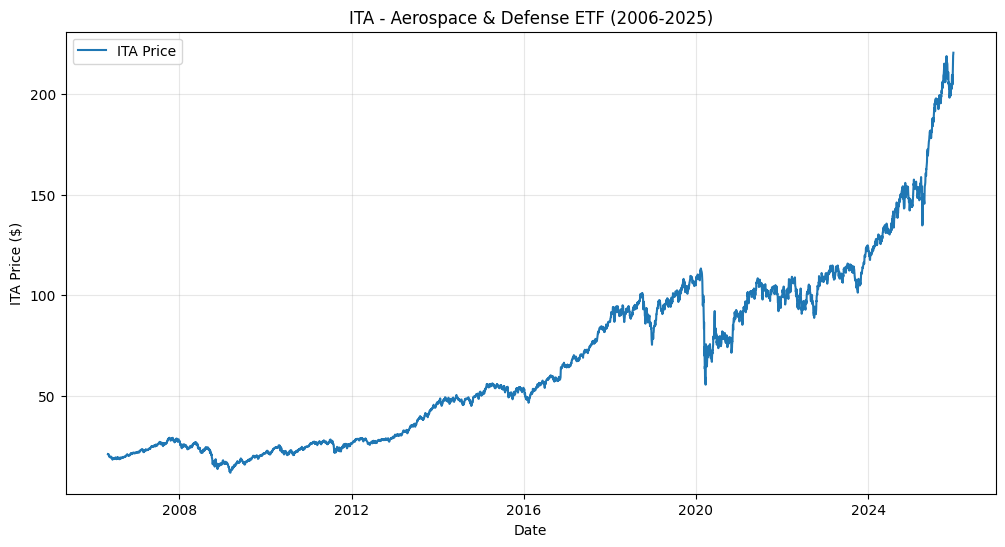

In [1]:
!pip install yfinance

import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim

# Additional libraries for data manipulation
# We'll use pandas and numpy, plus matplotlib for visuals
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading ITA Data from yfinance. Using ITA will give us data from 2006 till now. This will give us a complete picture of military and cyber-military events since 2006 that includes Stuxent (2008), Russia-Ukraine (2022) and Iron-Swords war in Israel (2023).
data = yf.download('ITA', start='2006-01-01', end='2025-12-30')

# Data Cleaning and Preparation
# We will use 'Adj close' because it accounts for dividends and stock splits.
if 'Adj Close' in data.columns:
    df_lstm = data[['Adj Close']].copy()
    df_lstm.rename(columns={'Adj Close': 'Close'}, inplace=True)
else:
    df_lstm = data[['Close']].copy()

df_lstm.dropna(inplace=True)

print(f"Total trading days: {len(df_lstm)}")
print(df_lstm.head())

# Plotting data for verification
plt.figure(figsize=(12, 6))
plt.plot(df_lstm.index, df_lstm['Close'], label='ITA Price')
plt.title('ITA - Aerospace & Defense ETF (2006-2025)')
plt.xlabel('Date')
plt.ylabel('ITA Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## II. Data Preparation and Preprocessing

In this part we normalize the values to [1, 0] range.

We also split the data so 20% will use for test and the rest for training.

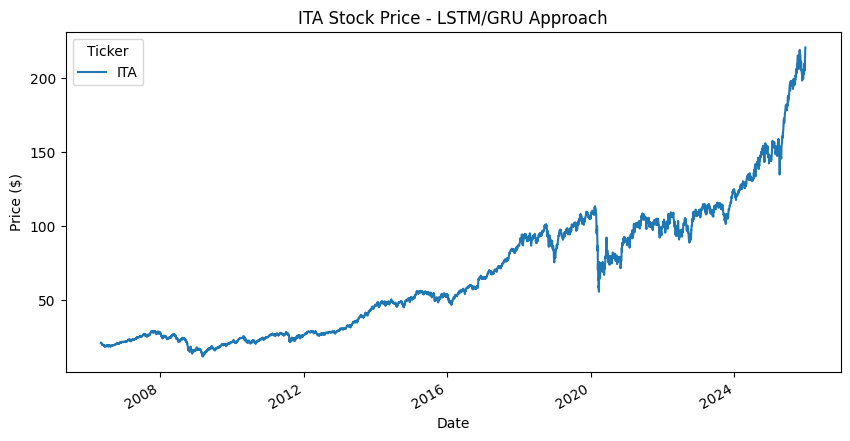

Train size: 3954, Test size: 988
X_train_t shape: torch.Size([3894, 60, 1]), Y_train_t shape: torch.Size([3894, 1])


C:\Users\danie\AppData\Local\Temp\ipykernel_21628\1940482359.py:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  X_test_t = torch.tensor(X_test_list, dtype=torch.float).to(device)


In [2]:
from sklearn.preprocessing import MinMaxScaler

df_lstm.plot(y='Close', figsize=(10, 5), title='ITA Stock Price - LSTM/GRU Approach')
plt.ylabel('Price ($)')
plt.show()

# Data normalization to [1, 0] range
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df_lstm[['Close']].values)

# Splitting for train and test sets, 20% of the data will use for testing
test_size = int(len(data_scaled) * 0.2)
train_size = len(data_scaled) - test_size

train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

print(f'Train size: {len(train_data)}, Test size: {len(test_data)}')

# Convert train/test to numpy arrays
train_np = train_data
test_np = test_data

# Setting sliding windows of 60 trade days to predict the 61st day.
def create_sequences_lstm(data, window=60):
    sequence_x = []
    sequence_y = []
    for i in range(len(data) - window):
        chunk = data[i:i+window]
        target = data[i+window]
        sequence_x.append(chunk)
        sequence_y.append(target)
    return sequence_x, sequence_y

# We'll create train sequences
X_train_list, Y_train_list = create_sequences_lstm(train_np, window=60)
X_test_list, Y_test_list = create_sequences_lstm(test_np, window=60)

# Convertion to arrays
X_train_arr = np.array(X_train_list, dtype = np.float32)
Y_train_arr = np.array(Y_train_list, dtype=np.float32)

X_test_arr = np.array(X_test_list, dtype=np.float32)
Y_test_arr = np.array(Y_test_list, dtype=np.float32)

# Convertion to torch tensors
X_train_t = torch.tensor(X_train_arr, dtype=torch.float).to(device)
Y_train_t = torch.tensor(Y_train_arr, dtype=torch.float).to(device)

X_test_t = torch.tensor(X_test_list, dtype=torch.float).to(device)
Y_test_t = torch.tensor(Y_test_list, dtype=torch.float).to(device)

print(f'X_train_t shape: {X_train_t.shape}, Y_train_t shape: {Y_train_t.shape}')

## III. Architecture & Training

Here we used the LSTM model as requested in this exercise.

### Structure:
* Input Dimensions: 1
* Hidden Layers: 2 of 64 units
* Outpus: 1 Linear Layer

### Hyperparameters:
* Optimizer: Adam
* Loss Function: MSE
* Epochs: 50
* Batch Size: 32

In [3]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class LSTM_Model(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(LSTM_Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

batch_size = 32
train_data = TensorDataset(X_train_t, Y_train_t)
test_data = TensorDataset(X_test_t, Y_test_t)

train_loader = DataLoader(train_data, shuffle=False,batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False,batch_size=batch_size)

model = LSTM_Model().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [4]:
epochs = 50
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    model.eval()
    test_loss_val = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss_val += loss.item()

    avg_test_loss = test_loss_val / len(test_loader)
    test_losses.append(avg_test_loss)

    if (epoch+1) % 5 == 0:
        print(f'Epoch: {epoch+1}/{epochs}, Train Loss: {epoch_loss:.3f}, Test Loss: {avg_test_loss:.3f}')

Epoch: 5/50, Train Loss: 0.016, Test Loss: 0.026
Epoch: 10/50, Train Loss: 0.002, Test Loss: 0.003
Epoch: 15/50, Train Loss: 0.001, Test Loss: 0.001
Epoch: 20/50, Train Loss: 0.000, Test Loss: 0.004
Epoch: 25/50, Train Loss: 0.000, Test Loss: 0.004
Epoch: 30/50, Train Loss: 0.000, Test Loss: 0.003
Epoch: 35/50, Train Loss: 0.000, Test Loss: 0.003
Epoch: 40/50, Train Loss: 0.000, Test Loss: 0.003
Epoch: 45/50, Train Loss: 0.000, Test Loss: 0.002
Epoch: 50/50, Train Loss: 0.000, Test Loss: 0.002


## Results Graph

As we see, the difference between the predicted price of ITA and the actual price is not significant.

The root mean squared error of the prediction compared to the actual values is 9.74$, which represents a difference of approximately **7-8%** for this ETF. This demonstrates the model's effectiveness in capturing the general trend.

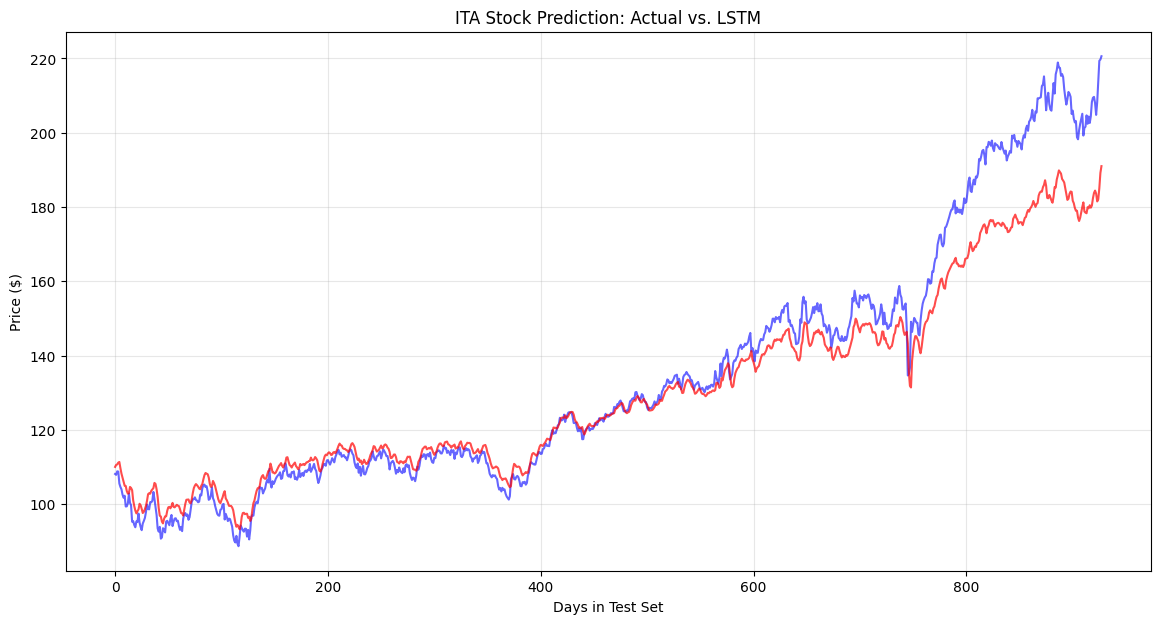

Root Mean Squared Error (RMSE): $9.74


In [6]:
model.eval()

preds = []
actuals = []


with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        preds.append(outputs.cpu().detach().numpy())
        actuals.append(labels.cpu().detach().numpy())

preds_arr = np.concatenate(preds)
actuals_arr = np.concatenate(actuals)

preds_real = scaler.inverse_transform(preds_arr)
actuals_real = scaler.inverse_transform(actuals_arr)

plt.figure(figsize=(14, 7))

plt.plot(actuals_real, label='Actual Price (ITA)', color='blue', alpha=0.6)
plt.plot(preds_real, label='LSTM Prediction', color='red', alpha=0.7)

plt.title('ITA Stock Prediction: Actual vs. LSTM')
plt.xlabel('Days in Test Set')
plt.ylabel('Price ($)')
plt.grid(True, alpha=0.3)
plt.show()

rmse = np.sqrt(np.mean((preds_real - actuals_real)**2))
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")